### 0. Inital package import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from scipy import stats
import json

# 1. Movie dataset preprocessing


### 1.1 Movie dataset import

In [3]:
movies_column_names = ['Wikipedia_movie_ID','Freebase_movie_ID','Movie_name','Movie_release_date','Movie_box_office_revenue','Movie_runtime','Movie_languages','Movie_countries','Movie_genres']
movies = pd.read_csv('..\data\movie.metadata.tsv', sep='\t', header=None,names=movies_column_names, decimal='.' )
movies.Movie_release_date = pd.to_datetime(movies.Movie_release_date,format='mixed', errors='coerce', utc=True)
print(len(movies))

81741


### 1.2 Preprocessing and analysis on movies country of origin and language

#### 1.2.1 Study of dataset country and language

A first step would be to see how much language and country per movies do we have, can we have only one language per movies ?

In [4]:
# Define the functions
def nb_items(vardict):
    # Extract ids and count them to get the number of items
    id = [id for id, name in eval(vardict).items()]
    return len(id)

def list_name_language(vardict):
    name = [name.replace("Language", "language").replace("language", "") for id, name in eval(vardict).items()]
    return name if name else None

def list_name(vardict):
    name = [name for id, name in eval(vardict).items()]
    return name if name else None

# number of languages and countries for each movie
movies["nb_languages"] = movies['Movie_languages'].apply(nb_items)
movies["nb_country"] = movies['Movie_countries'].apply(nb_items)
movies["nb_genre"] = movies['Movie_genres'].apply(nb_items)

movies["Movie_language"] = movies['Movie_languages'].apply(list_name_language)
movies["Movie_countries"] = movies['Movie_countries'].apply(list_name)
movies["Movie_genres"] = movies['Movie_genres'].apply(list_name)


#### Describing how many language and country the movies of the dataset have 

In [5]:
movies["nb_languages"].describe()

count    81741.000000
mean         0.994678
std          0.690623
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: nb_languages, dtype: float64

In [6]:
movies["nb_country"].describe()

count    81741.000000
mean         1.057474
std          0.623572
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         14.000000
Name: nb_country, dtype: float64

Text(0.5, 0, 'Number of countries or languages')

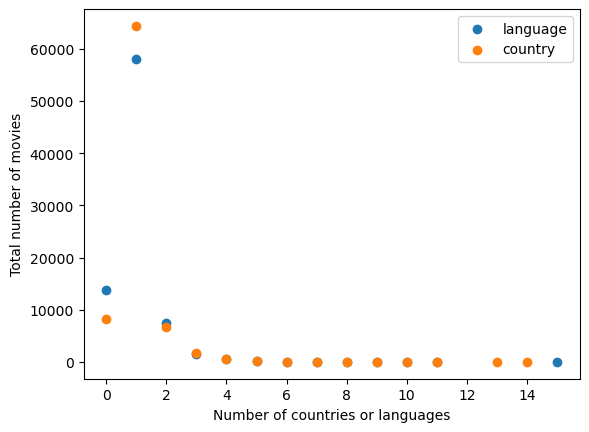

In [7]:
# If we focus on the occurence of each number of language and movies 
total_languages = movies.groupby("nb_languages")["nb_languages"].agg("count")
total_country = movies.groupby("nb_country")["nb_languages"].agg("count")

plt.figure()
plt.scatter(total_languages.index,total_languages.values, label = "language" )
plt.scatter(total_country.index,total_country, label = "country" )
plt.legend()
plt.ylabel("Total number of movies")
plt.xlabel("Number of countries or languages")

From the description and the plot of the total number of movies per number of languages and countries, it appears that the two variables have similar distributions in terms of total counts. However, do they have a similar distribution at the individual movie level? In other words, does a movie associated with 3 countries typically also have 3 languages? 

In [8]:
# correlation
stats.spearmanr(movies["nb_languages"], movies["nb_country"])

SignificanceResult(statistic=0.37307077954108103, pvalue=0.0)

The two variables seems to be moderatly to low correlated with a high confidence as it is seen with the p-value, thus there is a tendensy of increase of language per movies with the increase of number of countries but the correlation is not that strong

#### 1.2.2 Treating outliers

Now that we have studied this, how should we handle outliers? To address this, we can keep only the movies where the number of countries and the number of languages fall between the 5th and 95th percentiles

In [9]:

quantile_5 = np.quantile(movies.nb_languages, 0.05)
quantile_95 = np.quantile(movies.nb_languages, 0.95)

print(f"For language we will keep movies have a number of languages between the 5% percentiles {quantile_5} languages and the 95% percentiles {quantile_95} languages")

For language we will keep movies have a number of languages between the 5% percentiles 0.0 languages and the 95% percentiles 2.0 languages


In [10]:

quantile_5 = np.quantile(movies.nb_country, 0.05)
quantile_95 = np.quantile(movies.nb_country, 0.95)
print(f"For country we will keep movies have a number of countries between the 5% percentiles {quantile_5} countries and the 95% percentiles {quantile_95} countries")

For country we will keep movies have a number of countries between the 5% percentiles 0.0 countries and the 95% percentiles 2.0 countries


#### 1.2.3 Movies with more than 2 languages 

Lets focus a bit more on the movies out of the range 95 quantile, do they have something in common

In [11]:
movies_language_high = movies.loc[movies.nb_languages>2]
print(f"There is {len(movies_language_high)} with more than 2 languages")

There is 2319 with more than 2 languages


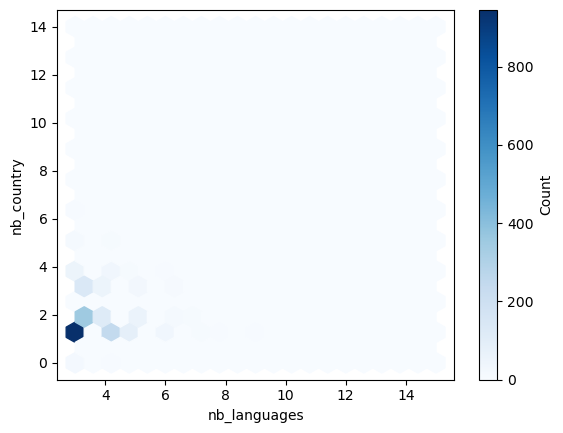

In [12]:


movies_language_high[["nb_languages","nb_country"]]

plt.hexbin(movies_language_high.nb_languages, movies_language_high.nb_country, gridsize=20, cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel('nb_languages')
plt.ylabel('nb_country')
plt.show()

In [13]:
movies_language_high.groupby("nb_country")["nb_country"].agg("count")

nb_country
0       29
1     1336
2      555
3      241
4      104
5       28
6       13
7        8
8        2
9        2
14       1
Name: nb_country, dtype: int64

We notice here that the majority of movies with more than 2 languages have actually 1 or 2 countries, we can than associate to these movies the language associated to the country they belong to.
To do this, we need to have for each country one main language, we will get this from the movies with 1 country and 1 language

In [14]:
country_language_all = movies.loc[(movies.nb_languages == 1) & (movies.nb_country == 1)].copy()
country_language_all["Movie_language"] = country_language_all["Movie_language"].apply(lambda x: x[0])
country_language_all["Movie_countries"] = country_language_all["Movie_countries"].apply(lambda x: x[0])
country_language_all = country_language_all.groupby(["Movie_language","Movie_countries"])["Movie_name"].agg("count").sort_values(ascending = False).reset_index()


In [15]:
# we keep the couple (language, movie) with the highest occurence
country_language_unique = country_language_all.drop_duplicates(subset=['Movie_countries'], keep='first')
country_language_unique = country_language_unique.reset_index(drop=True)

print(country_language_unique)

    Movie_language           Movie_countries  Movie_name
0         English   United States of America       23431
1         English             United Kingdom        4079
2           Hindi                      India        2865
3        Japanese                      Japan        1684
4         Italian                      Italy        1392
..             ...                       ...         ...
114        Arabic                      Libya           1
115    Macedonian      Republic of Macedonia           1
116     Malayalam         Malayalam Language           1
117     Mongolian                   Mongolia           1
118       Italian                     Cyprus           1

[119 rows x 3 columns]


Now that we have this link, we can assign one or two main languages to a movie based on its country. If the movie has a language that appears in the list of languages associated with a country, and the list contains more than two languages, and the movie is associated with one or two countries, we can extract those languages as the main language. We will apply this logic to famous movies that feature multiple languages.

In [16]:
movies_language_high.loc[movies_language_high['nb_country'] == 1, 'Movie_language']= \
    movies_language_high.loc[movies_language_high['nb_country'] == 1, 'Movie_countries'].copy().apply(
    lambda x: country_language_unique.loc[country_language_unique['Movie_countries'] == x[0],'Movie_language'].values)

movies_language_high.loc[movies_language_high['nb_country'] == 2, 'Movie_language'] = \
    movies_language_high.loc[movies_language_high['nb_country'] == 2, 'Movie_countries'].apply(
        lambda x: country_language_unique.loc[(country_language_unique['Movie_countries'] == x[0]) | 
            (country_language_unique['Movie_countries'] == x[1]),'Movie_language'].values)

movies_language_high.loc[:, "Movie_language"] = movies_language_high["Movie_language"].apply(lambda x: np.unique(x))


movies_language_high.sort_values(by = ["Movie_box_office_revenue"], ascending = False)[["Movie_name", "nb_languages","Movie_countries","Movie_language"]][:20]

Movie_name  nb_languages  \
22256                                            Titanic             6   
21432                                      The Lion King             4   
10820                Harry Potter and the Goblet of Fire             3   
60260                                          Inception             3   
33405  Indiana Jones and the Kingdom of the Crystal S...             3   
14453                                       Spider-Man 2             3   
53055                                               2012             9   
23863                                  The Da Vinci Code             4   
19034                                    The Incredibles             3   
64107                                          Fast Five             3   
72082                          The Passion of the Christ             6   
23491                                  Quantum of Solace             5   
46672                                           Iron Man             4   
23547                                Night at the Museum             3   
58885                                             Cars 2             4   
77243                             The Day After Tomorrow             5   
63183                                         Madagascar             5   
58622                                   Meet the Fockers             3   
32260                                  Angels and Demons             7   
24211                                Saving Private Ryan             4   

                                  Movie_countries Movie_language  
22256                  [United States of America]     [English ]  
21432                  [United States of America]     [English ]  
10820  [United States of America, United Kingdom]     [English ]  
60260  [United States of America, United Kingdom]     [English ]  
33405                  [United States of America]     [English ]  
14453                  [United States of America]     [English ]  
53055                  [United States of America]     [English ]  
23863                  [United States of America]     [English ]  
19034                  [United States of America]     [English ]  
64107                  [United States of America]     [English ]  
72082                  [United States of America]     [English ]  
23491  [United States of America, United Kingdom]     [English ]  
46672                  [United States of America]     [English ]  
23547  [United States of America, United Kingdom]     [English ]  
58885                  [United States of America]     [English ]  
77243                  [United States of America]     [English ]  
63183                  [United States of America]     [English ]  
58622                  [United States of America]     [English ]  
32260                  [United States of America]     [English ]  
24211                  [United States of America]     [English ]

In [17]:
movies.loc[movies.nb_languages>2] = movies_language_high

# lets upddate the nb of languages
movies.loc[movies.nb_languages>2, "nb_languages"] = movies.loc[movies.nb_languages>2, 'Movie_language'].apply(lambda x: len(x))
print(len(movies.loc[movies.nb_languages>2]))

428


using this, we go from 2319 movies with more than 2 languages to 428 movies 

#### 1.2.4 Movies with more than 2 countries

In [18]:
movies_country_high = movies.loc[movies.nb_country>2]
print(f"There is {len(movies_country_high)} with more than 2 countries")

There is 2500 with more than 2 countries


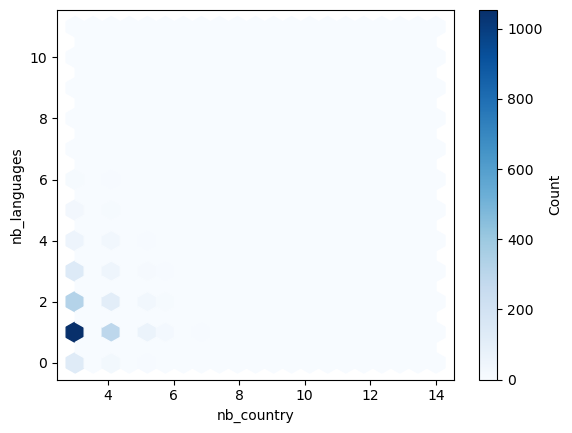

In [19]:
movies_country_high[["nb_languages","nb_country"]]

plt.hexbin(movies_country_high.nb_country,movies_country_high.nb_languages, gridsize=20, cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel('nb_country')
plt.ylabel('nb_languages')
plt.show()

In [20]:
movies_country_high.groupby("nb_languages")["nb_languages"].agg("count")

nb_languages
0      167
1     1447
2      487
3      217
4      102
5       46
6       23
7        5
8        3
9        1
11       2
Name: nb_languages, dtype: int64

We observe that for movies associated with multiple countries, most feature only one or two languages. This suggests that one or two primary countries are likely responsible for the majority of the film's production, while other listed countries may have contributed only a few scenes. Applying the same attribution method we used for languages does not seem appropriate in this context. For instance, if a movie is linked to three countries—such as the United States, the United Kingdom, and Australia—but has only one language, English, it becomes challenging to attribute the film to a single country. Therefore, we have decided to exclude the 2,500 movies that fall into this category.

#### 1.2.5 Movies with no language and no country

In [21]:
movies_no_language = movies.loc[movies.nb_languages == 0]
print(f"There is {len(movies_no_language)} with 0 language")

There is 13867 with 0 language


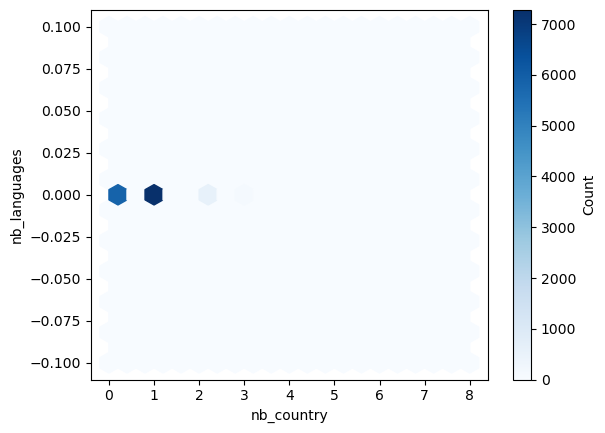

In [22]:
movies_no_language[["nb_languages","nb_country"]]

plt.hexbin(movies_no_language.nb_country,movies_no_language.nb_languages, gridsize=20, cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel('nb_country')
plt.ylabel('nb_languages')
plt.show()

In [23]:
movies_no_language.groupby("nb_country")["nb_country"].agg("count")

nb_country
0    5853
1    7278
2     569
3     131
4      27
5       6
6       2
8       1
Name: nb_country, dtype: int64

The majority of movies with 0 language have 1 or 2 countries 
Movies with 0 countries will be supressed

In [24]:
movies_no_language.loc[movies_no_language['nb_country'] == 1, 'Movie_language']= \
    movies_no_language.loc[movies_no_language['nb_country'] == 1, 'Movie_countries'].copy().apply(
    lambda x: country_language_unique.loc[country_language_unique['Movie_countries'] == x[0],'Movie_language'].values)

movies_no_language.loc[movies_no_language['nb_country'] == 2, 'Movie_language'] = \
    movies_no_language.loc[movies_no_language['nb_country'] == 2, 'Movie_countries'].apply(
        lambda x: country_language_unique.loc[
            (country_language_unique['Movie_countries'] == x[0]) | 
            (country_language_unique['Movie_countries'] == x[1]),
            'Movie_language'
        ].values)

movies_no_language.loc[:, "Movie_language"] = movies_no_language["Movie_language"].apply(lambda x: np.unique(x) if x is not None else x)


movies_no_language.sort_values(by = ["Movie_box_office_revenue"], ascending = False)[["Movie_name", "nb_country","nb_languages","Movie_countries","Movie_language"]][:20]

Movie_name  nb_country  \
49203                 Indiana Jones and the Last Crusade           0   
62570                   Journey 2: The Mysterious Island           1   
4812                                        The Dictator           0   
9339                                           Contagion           2   
18712                                          Chronicle           0   
5571                              Barbie: A Fairy Secret           0   
13706                                            To Fly!           1   
71026                    On His Majesty's Secret Service           0   
15109                                   The Devil Inside           0   
20514               What to Expect When You're Expecting           1   
27006                       Tinker, Tailor, Soldier, Spy           2   
46162                                       Bill & Ted 3           0   
47763                         The Founding of a Republic           1   
41667                Space Chimps 2: Zartog Strikes Back           1   
37200                                Once in a Blue Moon           0   
27364  Victini and the Black Hero: Zekrom and Victini...           0   
14211                                           Take Off           1   
34505                                          Red Tails           1   
64384                           Mardi Gras: Spring Break           0   
62148  Naruto the Movie: Snow Princess' Book of Ninja...           1   

       nb_languages                                   Movie_countries  \
49203             0                                              None   
62570             0                        [United States of America]   
4812              0                                              None   
9339              0  [United States of America, United Arab Emirates]   
18712             0                                              None   
5571              0                                              None   
13706             0                        [United States of America]   
71026             0                                              None   
15109             0                                              None   
20514             0                        [United States of America]   
27006             0                          [France, United Kingdom]   
46162             0                                              None   
47763             0                                           [China]   
41667             0                        [United States of America]   
37200             0                                              None   
27364             0                                              None   
14211             0                                     [South Korea]   
34505             0                        [United States of America]   
64384             0                                              None   
62148             0                                           [Japan]   

            Movie_language  
49203                 None  
62570           [English ]  
4812                  None  
9339            [English ]  
18712                 None  
5571                  None  
13706           [English ]  
71026                 None  
15109                 None  
20514           [English ]  
27006  [English , French ]  
46162                 None  
47763  [Standard Mandarin]  
41667           [English ]  
37200                 None  
27364                 None  
14211            [Korean ]  
34505           [English ]  
64384                 None  
62148          [Japanese ]

In [25]:
movies.loc[movies.nb_languages==0] = movies_no_language

# lets upddate the nb of languages
movies.loc[movies.nb_languages==0, "nb_languages"] = movies.loc[movies.nb_languages==0, 'Movie_language'].apply(lambda x: len(x)if x is not None else 0)
print(len(movies.loc[movies.nb_languages==0]))

6030


with this we reduce the number of movies with 0 languages by half

#### 1.2.6 Extracting language and country

Keep only the movies that have 1 or 2 language and 1 or 2 country

In [26]:
movies = movies.loc[(movies.nb_languages <= 2) &(movies.nb_languages > 0) & (movies.nb_country <= 2) & (movies.nb_country >0 )]

Extract and add the 2 main language and 2 main countries for each movie. If the movie only has one main language or main countries, the second value will be "None"

In [27]:
def get_name(list_items):
    if list_items is None: 
        return None, None
    if len(list_items) == 1:
        return list_items[0], None
    elif len(list_items) == 2:
        return list_items[0], list_items[1]
    return None, None



In [28]:
movies[['FirstLanguage_Name', 'SecondLanguage_Name']] = movies['Movie_language'].apply(lambda x: pd.Series(get_name(x)))
movies[['FirstCountry_Name', 'SecondCountry_Name']] = movies['Movie_countries'].apply(lambda x: pd.Series(get_name(x)))

#### 1.2.7 Plots of the final dataset 

Let's look at the 20 most frequently used languages in movies. To do this, we will sum the occurrences of each language as both the first and second language in the data. This gives the total number of movies in which each language appears, meaning that some movies may be counted twice if they contain the language as both primary and secondary.

In [29]:
movies_language1 = movies['FirstLanguage_Name'].dropna().value_counts(ascending=False).reset_index()
movies_language1.columns = ['Language', 'Count']
movies_language1 = movies_language1.set_index('Language')
movies_language2 = movies['SecondLanguage_Name'].dropna().value_counts(ascending=False).reset_index()
movies_language2.columns = ['Language', 'Count']
movies_language2 = movies_language2.set_index('Language').reindex(movies_language1.index, fill_value=0)

merged_languages = movies_language1.merge(movies_language2, left_index=True , right_index=True)
merged_languages["total"] = merged_languages["Count_x"] + merged_languages["Count_y"]
merged_languages = merged_languages.sort_values(by=["total"], ascending = False)


Text(0.5, 1.0, 'Number of movies per language')

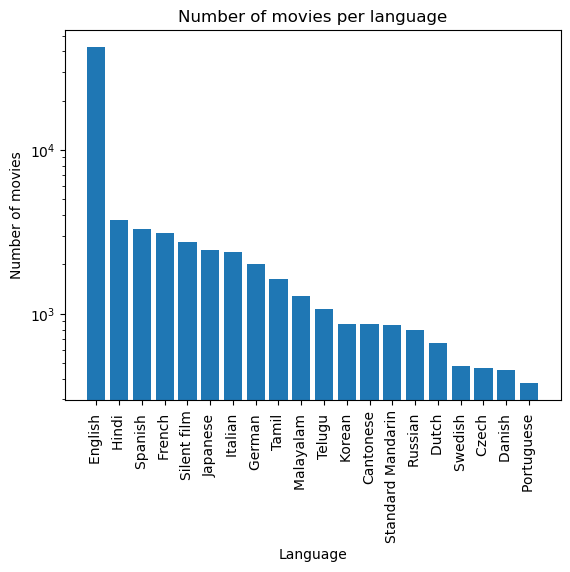

In [30]:

plt.figsize = (15,8)
plt.bar(merged_languages["total"].index[:20],merged_languages["total"][:20])
plt.yscale("log")
plt.xticks(rotation ='vertical',fontsize=10)
plt.ylabel("Number of movies")
plt.xlabel("Language")
plt.title("Number of movies per language")



Now we will do the same for country

In [31]:
movies_country1 = movies['FirstCountry_Name'].dropna().value_counts(ascending=False).reset_index()
movies_country1.columns = ['country', 'Count']
movies_country1 = movies_country1.set_index('country')
movies_country2 = movies['SecondCountry_Name'].dropna().value_counts(ascending=False).reset_index()
movies_country2.columns = ['country', 'Count']
movies_country2 = movies_country2.set_index('country').reindex(movies_country1.index, fill_value=0)

merged_country = movies_country1.merge(movies_country2, left_index=True , right_index=True)
merged_country["total"] = merged_country["Count_x"] + merged_country["Count_y"]
merged_country = merged_country.sort_values(by=["total"], ascending = False)



Text(0.5, 1.0, 'Number of movies per country')

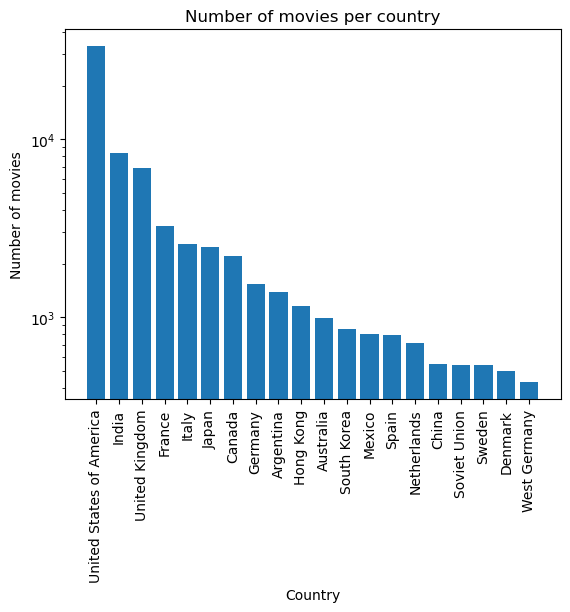

In [32]:
plt.figsize = (15,8)
plt.bar(merged_country["total"].index[:20],merged_country["total"][:20])
plt.yscale("log")
plt.xticks(rotation ='vertical',fontsize=10)
plt.ylabel("Number of movies")
plt.xlabel("Country")
plt.title("Number of movies per country")



### 1.3 Preprocessing and analysis on movies genre

Let's focus now on movies genre, lets see how many genre are attributed to each movie

In [33]:
movies["nb_genre"].describe()

count    71077.000000
mean         3.083628
std          2.104797
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max         17.000000
Name: nb_genre, dtype: float64

Text(0.5, 1.0, 'Number of movies per number of genres')

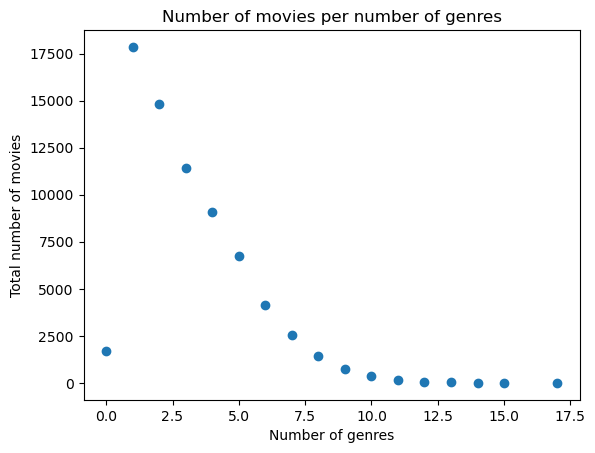

In [34]:
total_genre = movies.groupby("nb_genre")["nb_genre"].agg("count")

plt.figure()
plt.scatter(total_genre.index,total_genre.values)
plt.ylabel("Total number of movies")
plt.xlabel("Number of genres")
plt.title("Number of movies per number of genres")

Text(0.5, 1.0, 'Number of genres per movie')

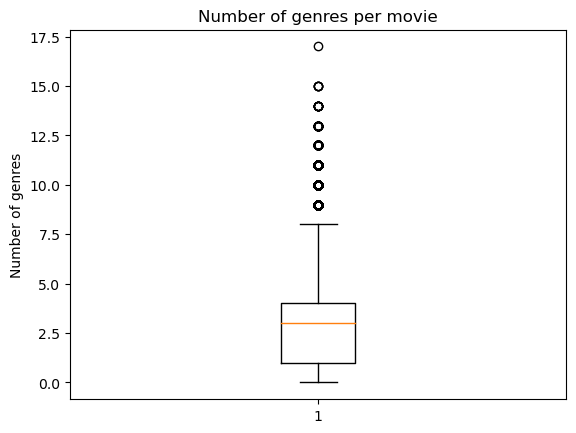

In [35]:
plt.boxplot(movies.nb_genre)
plt.ylabel("Number of genres")
plt.title("Number of genres per movie")

### 1.4 Preprocessing and analysis on movies runtime

In [36]:
print(movies.Movie_runtime.describe())

# number of Nan in Runtime
print()
print("percentage of Nan in  runtime")
movies.Movie_runtime.isnull().sum()/ len(movies.Movie_runtime)

count    5.527700e+04
mean     1.133363e+02
std      4.590700e+03
min      0.000000e+00
25%      8.100000e+01
50%      9.300000e+01
75%      1.060000e+02
max      1.079281e+06
Name: Movie_runtime, dtype: float64

percentage of Nan in  runtime


0.22229413171630766

In [37]:

quantile_5 = np.quantile(movies.Movie_runtime.dropna(), 0.05)
quantile_95 = np.quantile(movies.Movie_runtime.dropna(), 0.95)
print(f" 5% percentiles {quantile_5} minutes and the 95% percentiles {quantile_95} minutes")

 5% percentiles 20.0 minutes and the 95% percentiles 148.0 minutes


the 95 percentile don't seem that long lets, focus on movies whith the highest runtime and other quantiles

In [38]:
movies.sort_values(by = ['Movie_runtime'], ascending = False).head(10)


Wikipedia_movie_ID Freebase_movie_ID  \
12804            10815585        /m/02qqy23   
71100            25345684        /m/09gqhh3   
21733            14545195        /m/03qcghh   
46666              884435         /m/03lmv2   
16316            21689271        /m/05q4cg8   
27036            36136594        /m/0k0ryr0   
68223              884492         /m/03lm_0   
73658             1348747         /m/04vq_r   
73630             6012645         /m/0fkkf0   
30259              884506         /m/03ln0w   

                                            Movie_name  \
12804                                   Zero Tolerance   
71100                                        Cinématon   
21733                                      Matrjoschka   
46666                            The Cure for Insomnia   
16316                               Paradise in Harlem   
27036                             Kai Koduttha Dheivam   
68223  The Longest Most Meaningless Movie in the World   
73658                                         Gigantor   
73630                            Dil Ne Phir Yaad Kiya   
30259              The Burning of the Red Lotus Temple   

             Movie_release_date  Movie_box_office_revenue  Movie_runtime  \
12804 1995-01-01 00:00:00+00:00                       NaN     1079281.00   
71100 2011-01-01 00:00:00+00:00                       NaN        9360.00   
21733 2006-04-23 00:00:00+00:00                       NaN        5700.00   
46666 1987-01-31 00:00:00+00:00                       NaN        5220.00   
16316                       NaT                       NaN        5100.00   
27036 1964-07-18 00:00:00+00:00                       NaN        4875.27   
68223 1968-01-01 00:00:00+00:00                       NaN        2880.00   
73658 1963-10-20 00:00:00+00:00                       NaN        2425.00   
73630 1966-01-01 00:00:00+00:00                       NaN        1966.00   
30259 1928-05-13 00:00:00+00:00                       NaN        1620.00   

                          Movie_languages             Movie_countries  \
12804  {"/m/02h40lc": "English Language"}  [United States of America]   
71100   {"/m/064_8sq": "French Language"}                    [France]   
21733                                  {}                   [Germany]   
46666  {"/m/02h40lc": "English Language"}  [United States of America]   
16316                                  {}  [United States of America]   
27036      {"/m/07c9s": "Tamil Language"}                     [India]   
68223  {"/m/02h40lc": "English Language"}            [United Kingdom]   
73658  {"/m/02h40lc": "English Language"}                     [Japan]   
73630      {"/m/03k50": "Hindi Language"}                     [India]   
30259                                  {}                     [China]   

                                            Movie_genres  nb_languages  \
12804  [Thriller, Crime Fiction, Action, Indie, Actio...             1   
71100                   [Experimental film, Documentary]             1   
21733                               [Indie, Documentary]             1   
46666                                         [Art film]             1   
16316                             [Crime Fiction, Drama]             1   
27036                                               None             1   
68223                                [Experimental film]             1   
73658  [Thriller, Science Fiction, Anime, Action, Ani...             1   
73630                          [Bollywood, World cinema]             1   
30259            [Silent film, Martial Arts Film, Drama]             1   

       nb_country  nb_genre       Movie_language FirstLanguage_Name  \
12804           1         5           [English ]           English    
71100           1         2            [French ]            French    
21733           1         2            [German ]            German    
46666           1         1           [English ]           English    
16316           1         2           [

The first one of 17 988 hours is actually an error, as no movies of this length exist in the record ( the longest movie ever is of 857 hours) when searching online.

we decided to keep only movies with a length smaller than the 99.5 quantile

In [39]:
quantile_995 = np.quantile(movies.Movie_runtime.dropna(), 0.999)
quantile_995

389.17200000000594

Now lets focus on the short movies of less then 20 minutes


In [40]:
short_movies = movies.loc[((movies.Movie_runtime <quantile_5))]

# check if short film is in the list of genre
sum = 0
for j in short_movies["Movie_genres"]:
    sum += j.count("Short Film")

if sum == len(short_movies):
    print("All movies bellow 20 minutes have a genre short film")

All movies bellow 20 minutes have a genre short film


In [41]:
movies = movies.loc[((movies.Movie_runtime > quantile_5) & (movies.Movie_runtime < quantile_995)) |  (movies.Movie_runtime.isna())]

### 1.5 Preprocessing and analysis on movie revenues

In [42]:
print(movies.Movie_box_office_revenue.describe())

# number of Nan in Runtime
print()
print("percentage of Nan")
movies.Movie_box_office_revenue.isnull().sum()/ len(movies.Movie_box_office_revenue)

count    7.661000e+03
mean     4.831926e+07
std      1.141140e+08
min      1.000000e+04
25%      2.100000e+06
50%      1.060050e+07
75%      4.070800e+07
max      2.782275e+09
Name: Movie_box_office_revenue, dtype: float64

percentage of Nan


0.8876916761955024

 ### 1.6 Preprocessing and anaylisis on movies release year

In [43]:
movies.Movie_release_date.dt.year.describe()

count    64409.000000
mean      1977.556133
std         27.958917
min       1889.000000
25%       1956.000000
50%       1984.000000
75%       2003.000000
max       2016.000000
Name: Movie_release_date, dtype: float64

In [44]:
#percentage of Nan
movies.Movie_release_date.isnull().sum()/ len(movies.Movie_release_date)*100

5.57803383469669

Text(0.5, 1.0, 'Number of movies released per year')

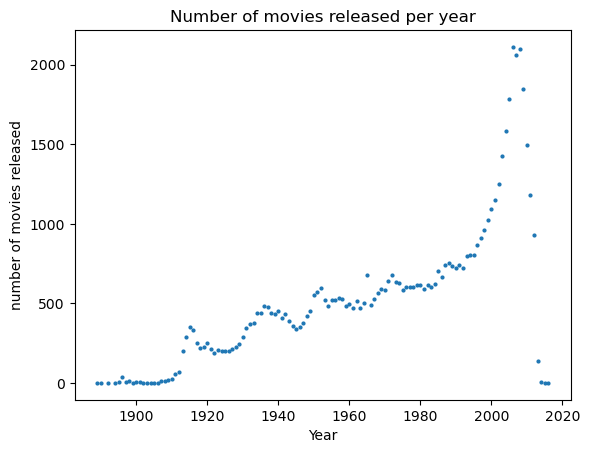

In [45]:
# not cleaned 
yearly_movies = movies.groupby(movies.Movie_release_date.dt.year)['Movie_release_date'].agg('count')
plt.scatter(yearly_movies.index, yearly_movies, s= 4)
plt.ylabel("number of movies released")
plt.xlabel("Year")
plt.title("Number of movies released per year")

Text(0.5, 1.0, 'Movies Language per year')

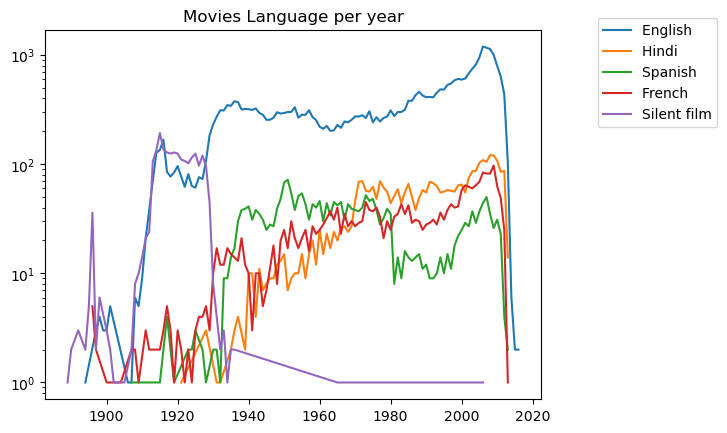

In [46]:

for language in merged_languages.index[:5]:
    movies_language_year = movies.loc[movies.FirstLanguage_Name == language].groupby(movies.Movie_release_date.dt.year)['FirstLanguage_Name'].agg('size')
    plt.plot(movies_language_year, label = language)
    plt.yscale('log')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Movies Language per year")

Text(0.5, 1.0, 'Movies Language per year')

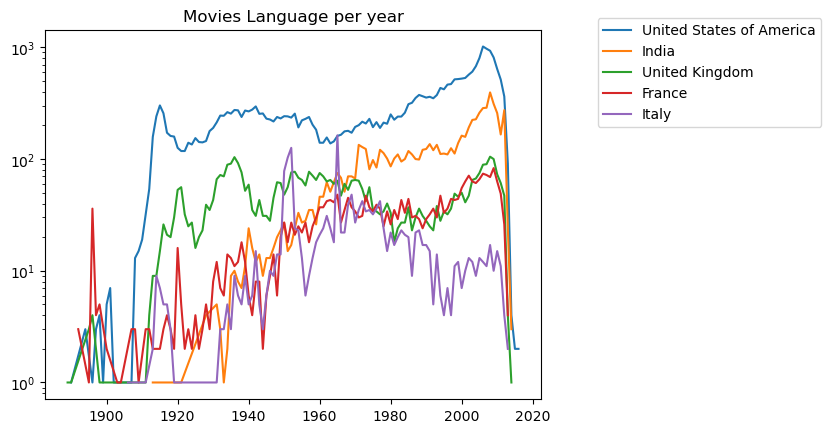

In [47]:
for country in merged_country.index[:5]:
    movies_country_year = movies.loc[movies.FirstCountry_Name == country].groupby(movies.Movie_release_date.dt.year)['FirstCountry_Name'].agg('size')
    plt.plot(movies_country_year, label = country)
    plt.yscale('log')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Movies Language per year")

### 1.7 Save the new movie dataset 

In [48]:
movies.to_pickle('../../data/movies.pkl')


# 2. TV tropes Dataset preoprocessing

### 2.1 Import and format the dataset

In [49]:
tvtropes = pd.read_csv('../data/tvtropes.clusters.txt', sep="\t", quoting = 3, header = None, on_bad_lines='skip')
tvtropes.columns = ["Role", "data"]
parsed_data = tvtropes["data"].apply(lambda x: pd.Series(json.loads(x)))
tvtropes = pd.concat([tvtropes["Role"], parsed_data], axis=1)
tvtropes = tvtropes.rename(columns={'char': 'Character_name', 'movie': 'Movie_name','id':'Freebase_character/actor_map_ID','actor':'Actor_name'})

tvtropes.Role = tvtropes.Role.str.replace('_', ' ')
tvtropes.head()

Role             Character_name   Movie_name  \
0  absent minded professor  Professor Philip Brainard      Flubber   
1  absent minded professor         Professor Keenbean  Richie Rich   
2  absent minded professor         Dr. Reinhardt Lane   The Shadow   
3  absent minded professor         Dr. Harold Medford        Them!   
4  absent minded professor             Daniel Jackson     Stargate   

  Freebase_character/actor_map_ID       Actor_name  
0                       /m/0jy9q0   Robin Williams  
1                      /m/02vchl3  Michael McShane  
2                       /m/0k6fkc     Ian McKellen  
3                       /m/0k6_br     Edmund Gwenn  
4                       /m/0k3rhh     James Spader

### 2.2 Plots to describe the TV tropes dataset

Text(0.5, 1.0, 'Number of characters per role')

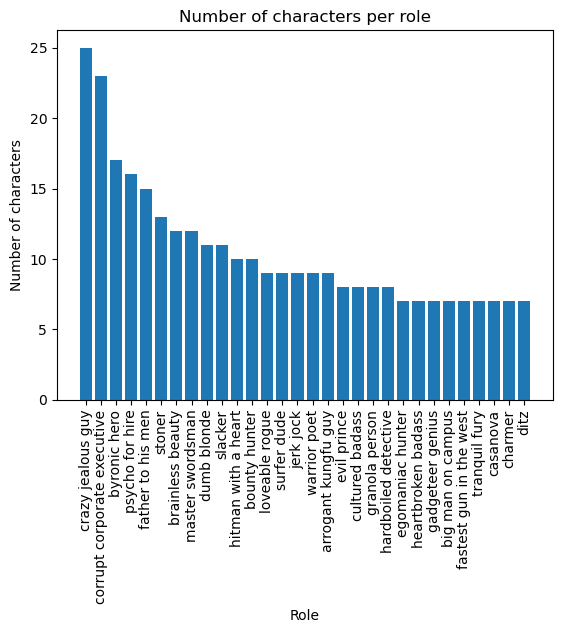

In [50]:
plt.bar( tvtropes.Role.value_counts().index[:30], tvtropes.Role.value_counts()[:30])
plt.xticks(rotation ='vertical',fontsize=10)
plt.ylabel("Number of characters")
plt.xlabel("Role")
plt.title("Number of characters per role")

Text(0.5, 1.0, 'Number of character appearances in the same role')

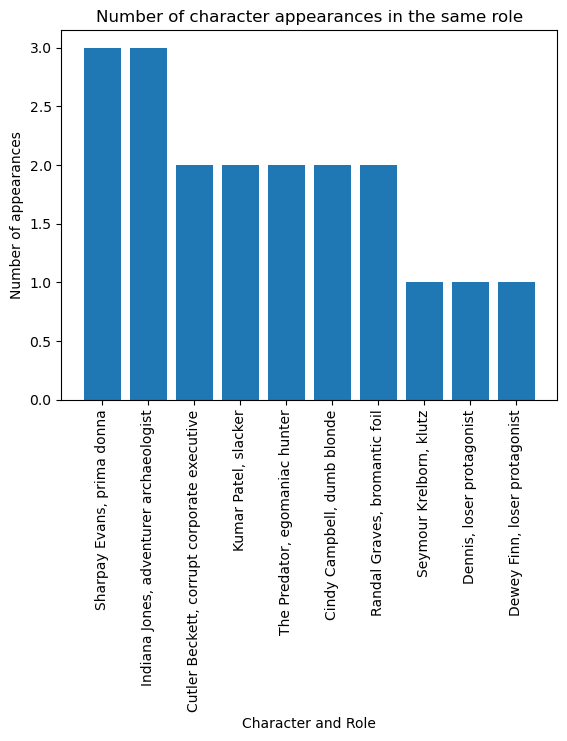

In [51]:
unique_character = tvtropes.drop(['Freebase_character/actor_map_ID','Actor_name','Movie_name'], axis = 1).value_counts()
unique_character = pd.DataFrame(unique_character)
unique_character.reset_index(inplace=True)
#.Role()+ unique_character.Character_name(), unique_character)
plt.bar(unique_character.Character_name[:10]+', '+unique_character.Role[:10], unique_character["count"][:10])
plt.xticks(rotation ='vertical',fontsize=10)
plt.ylabel("Number of appearances")
plt.xlabel("Character and Role")
plt.title("Number of character appearances in the same role")

### 2.3 Save TV tropes dataset

In [52]:
tvtropes.to_pickle('../../data/tvtropes.pkl')

# 3 Movie plot dataset preprocessing

### 3.1 Import and format movieplot dataset

In [53]:
summaries = pd.read_csv('../data/plot_summaries.txt', sep="\t", quoting = 3, header = None, on_bad_lines='skip')
summaries.columns = ["Wikipedia_movie_ID", "Plot"]
summaries.head()

Wikipedia_movie_ID                                               Plot
0            23890098  Shlykov, a hard-working taxi driver and Lyosha...
1            31186339  The nation of Panem consists of a wealthy Capi...
2            20663735  Poovalli Induchoodan  is sentenced for six yea...
3             2231378  The Lemon Drop Kid , a New York City swindler,...
4              595909  Seventh-day Adventist Church pastor Michael Ch...

Some movies have the same plot but different Wikipedia Movie ID : 

In [54]:
plot_duplicate = summaries[summaries.Plot.isin(summaries.Plot.value_counts().index[0:5])]
plot_duplicate

Wikipedia_movie_ID                                               Plot
8048             20904516  Raja was adopted by a criminal don  at a very ...
10573            14037732  A woman is thrown out of her home by her jealo...
14634            14055212  A woman is thrown out of her home by her jealo...
19678            10791940  Taking a step aside from the usual serious dra...
22056            28852030  As the American Civil War begins, Ned Burton l...
29079            25493367  An orphan Raghav turns into a ruthless contrac...
29431            14022275  A woman is thrown out of her home by her jealo...
30990            14051944  A woman is thrown out of her home by her jealo...
31705            14053389  A woman is thrown out of her home by her jealo...
35061            19609453  Raja was adopted by a criminal don  at a very ...
38539            14616220  As the American Civil War begins, Ned Burton l...
38834            10791937  Taking a step aside from the usual serious dra...
39022            29481480  An orphan Raghav turns into a ruthless contrac...

It turns out it is movie that have been remade several time accross the years and the plot stays the same. So we can keep them to keep a link with the actors of each movie. 

### Save the plot summaries dataset

In [55]:
summaries.to_pickle('../../data/plot_summaries.pkl')

# 4 Characters Metadata

### 4.1 Import and format the dataset

In [57]:
# Load the character metadata using relative path
character_metadata = pd.read_csv("../data/character.metadata.tsv", sep='\t')

column_names = ['Wikipedia_Movie_ID', 'Freebase_Movie_ID', 'Movie_Release_Date', 'Character_Name', 'Actor_DOB', 'Actor_Gender', 'Actor_Height', 'Actor_Ethnicity', 'Actor_Name', 'Actor_Age_At_Movie_Release', 'Freebase_Character_Actor_Map_ID', 'Freebase_character_ID', 'Freebase_Actor_ID']
character_metadata.columns = column_names

character_metadata.sample(5)

Wikipedia_Movie_ID Freebase_Movie_ID Movie_Release_Date  \
149662            33268353        /m/0h7llfs         2011-04-15   
201563            20959633        /m/05b5ss2         2008-12-09   
162263             5455247         /m/0dmnsc               1967   
39458              5949974         /m/0fg6dj         2007-01-26   
225434             3112996         /m/08s6ry         1990-02-16   

       Character_Name   Actor_DOB Actor_Gender  Actor_Height Actor_Ethnicity  \
149662           Ljak        1967            M           NaN             NaN   
201563            NaN         NaN            M           NaN             NaN   
162263   Doc Holliday  1922-07-26            M         1.765             NaN   
39458     Abdul Dicky         NaN            M           NaN      /m/0dryh9k   
225434            NaN         NaN          NaN           NaN             NaN   

              Actor_Name  Actor_Age_At_Movie_Release  \
149662  Toni Mihajlovski                        44.0   
201563        Jeff Lewis                         NaN   
162263     Jason Robards                        44.0   
39458         Vijay Raaz                         NaN   
225434        Elsie Eide                         NaN   

       Freebase_Character_Actor_Map_ID Freebase_character_ID Freebase_Actor_ID  
149662                      /m/0j50x24            /m/0j5r1jg        /m/0gm3rr8  
201563                      /m/0csb1xk                   NaN        /m/05p8f_g  
162263                      /m/04d8gys            /m/0c0n6yk         /m/01tcf7  
39458                       /m/0cgnx6n            /m/0h6yx0l        /m/0270bv0  
225434                      /m/0j1b8ns                   NaN        /m/0j1b8nw



For conveniance, we will add a new line called Movie_Release_Year that contains the year of release instead of the precise date. This will allow us to plot the distribution of movie year of release more nicely. We add the attribute "format = 'mixed'" because the movie release date is presented in different formats depending on the movie. Avoiding this attribute would lead to a considerable amount of NaN values in the release year, even for movies that actually have a non NaN release date.

We repeat the same procedure for the actor date of birth.


In [58]:
character_metadata['Actor_DOB'] = pd.to_datetime(character_metadata['Actor_DOB'], format = 'mixed', errors='coerce')


character_metadata['Movie_Release_Date'] = pd.to_datetime(character_metadata['Movie_Release_Date'], format = 'mixed', errors='coerce', utc=True)
character_metadata['Movie_Release_Year'] = character_metadata['Movie_Release_Date'].dt.year


character_metadata['Actor_DOB'] = pd.to_datetime(character_metadata['Actor_DOB'], format = 'mixed', errors='coerce', utc=True)
character_metadata['Actor_YOB'] = character_metadata['Actor_DOB'].dt.year

character_metadata.sample(5)

C:\Users\Theodore\AppData\Local\Temp\ipykernel_24808\1039685591.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  character_metadata['Actor_DOB'] = pd.to_datetime(character_metadata['Actor_DOB'], format = 'mixed', errors='coerce')


Wikipedia_Movie_ID Freebase_Movie_ID        Movie_Release_Date  \
106884             1413265         /m/04_hmd 2004-12-12 00:00:00+00:00   
148977            11373326        /m/02r9b97 1959-01-01 00:00:00+00:00   
124055            10620253        /m/02qkfh5 1975-05-30 00:00:00+00:00   
170572              423019         /m/026pdy 1995-01-01 00:00:00+00:00   
373098            12276844        /m/02vymsm 2005-01-01 00:00:00+00:00   

       Character_Name                 Actor_DOB Actor_Gender  Actor_Height  \
106884      Mushmouth 1982-12-31 00:00:00+00:00            M           NaN   
148977  Seth Sewakram 1910-01-01 00:00:00+00:00            M           NaN   
124055   Vikram Singh 1922-01-01 00:00:00+00:00            M           NaN   
170572            NaN 1978-02-21 00:00:00+00:00            F           NaN   
373098            NaN 1953-03-18 00:00:00+00:00            F           NaN   

       Actor_Ethnicity         Actor_Name  Actor_Age_At_Movie_Release  \
106884             NaN  Jermaine Williams                        21.0   
148977      /m/0dryh9k            Motilal                        48.0   
124055      /m/0dryh9k           Iftekhar                        53.0   
170572             NaN         Miki Sakai                        16.0   
373098             NaN     Teresa Madruga                        51.0   

       Freebase_Character_Actor_Map_ID Freebase_character_ID  \
106884                       /m/0jy35g            /m/0h5t9vb   
148977                      /m/0h79_d5            /m/0h79_d7   
124055                      /m/03jpfl2            /m/0h8k08_   
170572                      /m/0ggfmj0                   NaN   
373098                      /m/0gcbwvl                   NaN   

       Freebase_Actor_ID  Movie_Release_Year  Actor_YOB  
106884         /m/0gs3x3              2004.0     1982.0  
148977         /m/0ccn56              1959.0     1910.0  
124055        /m/02qnk5c              1975.0     1922.0  
170572        /m/03mdg83              1995.0     1978.0  
373098        /m/0fpjx26              2005.0     1953.0

Let's have a look at the distribution of some features ! In this notebook, we apply the same preprocessing methodology to other features but we do not plot every single feature for the sake of readability.

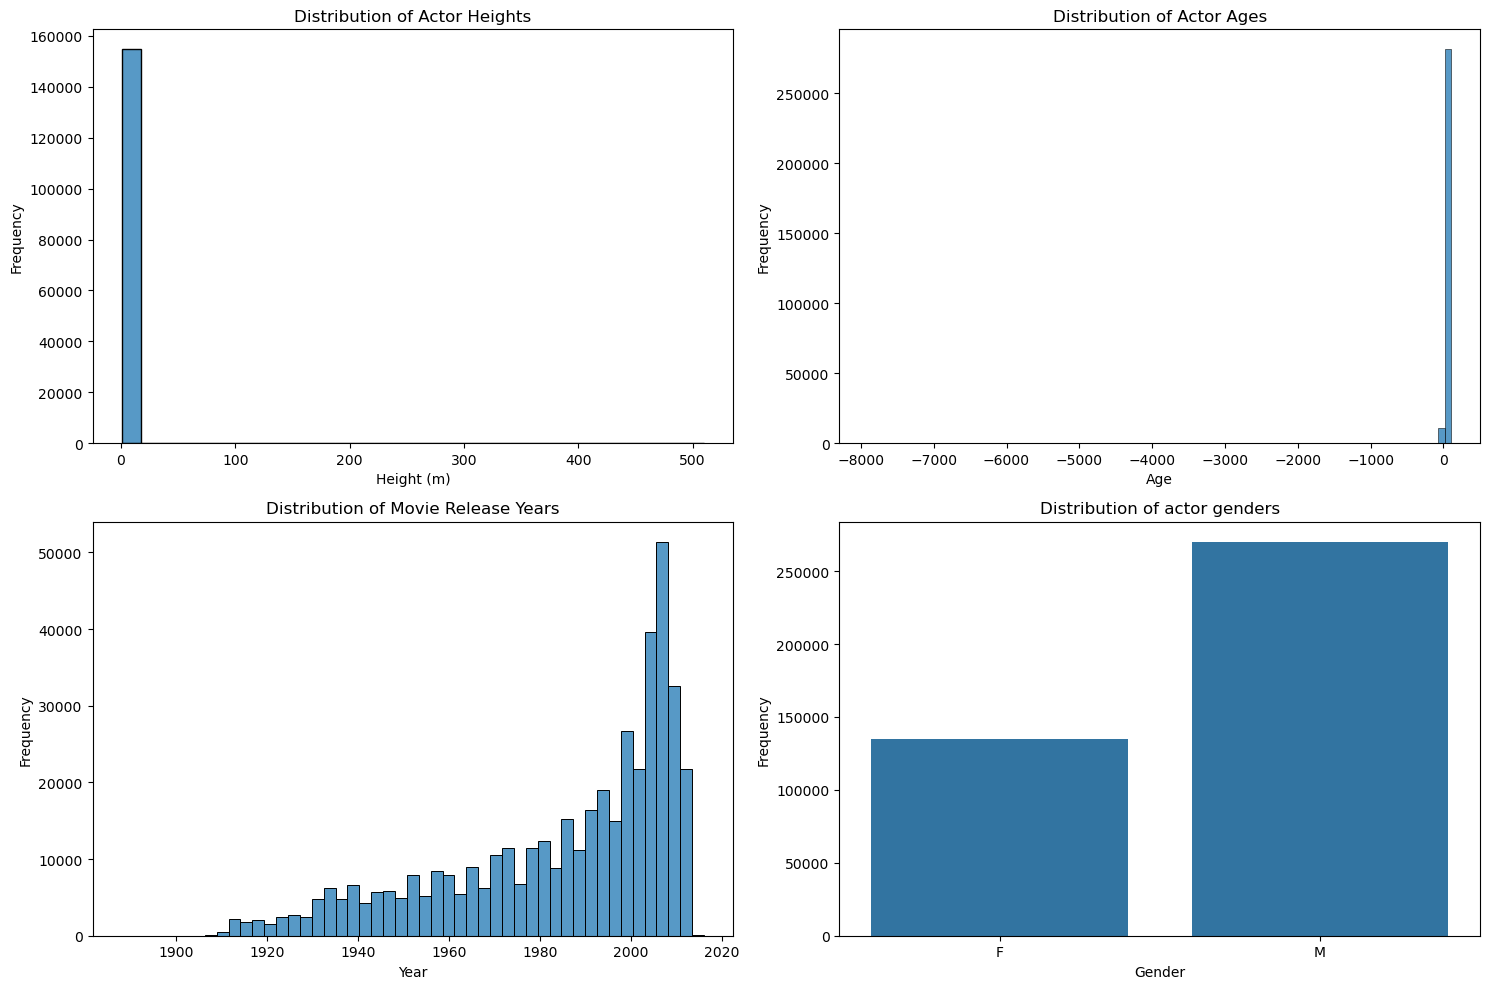

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(character_metadata['Actor_Height'], bins=30, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Actor Heights')
axs[0, 0].set_xlabel('Height (m)')
axs[0, 0].set_ylabel('Frequency')

sns.histplot(character_metadata['Actor_Age_At_Movie_Release'], bins=92, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of Actor Ages')
axs[0, 1].set_xlabel('Age')
axs[0, 1].set_ylabel('Frequency')

sns.histplot(character_metadata['Movie_Release_Year'], bins=49, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of Movie Release Years')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Frequency')

sns.countplot(data=character_metadata, x='Actor_Gender', ax=axs[1, 1])
axs[1, 1].set_title('Distribution of actor genders')
axs[1, 1].set_xlabel('Gender')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



We can observe that some values seem aberrant. We will have to clean the dataset to make sure to have reasonnable data.


### 4.2 General preprocessing

We will first do a general preprocessing, and then we will focus on cleaning our data according to our subject of study. The general preprocessing will lead to a relatively small amount of data, but will be conveniant if we want to run a quick analysis on some specific features afterwards.

#### 4.2.1 Droping All NaNs and NaTs

Before dropping the missing values, we check their proportion for each feature of our dataset.


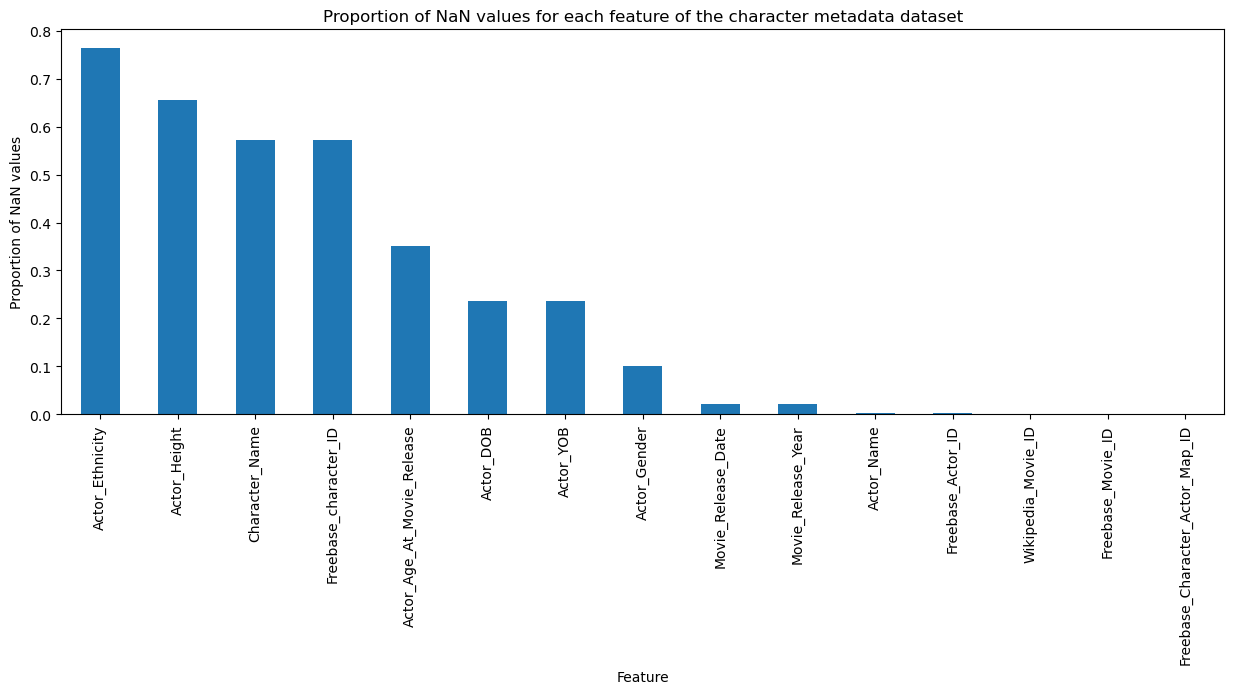

In [60]:
nan_proportions = character_metadata.isna().mean().sort_values(ascending=False)
nan_proportions.plot(kind='bar', figsize=(15, 5))
plt.title('Proportion of NaN values for each feature of the character metadata dataset')
plt.xlabel('Feature')
plt.ylabel('Proportion of NaN values')
plt.show()



We observe that some features contain a big amount of missing values, and we will need to be carefull about these features.

For now we do not focus on any feature, and we decide to drop every single empty values. As observed above, some columns have a majority of empty values, so dropping all the NaNs might not be a good idea when we want to do a targeted analysis. But for now we want a very general preprocessing, and we will later be more cautious.



In [61]:
copy1 = character_metadata.copy()
clean_data = copy1.dropna()

print("Length of original data: ", len(character_metadata), "Length of cleaned data: ", len(clean_data))

Length of original data:  450668 Length of cleaned data:  45264


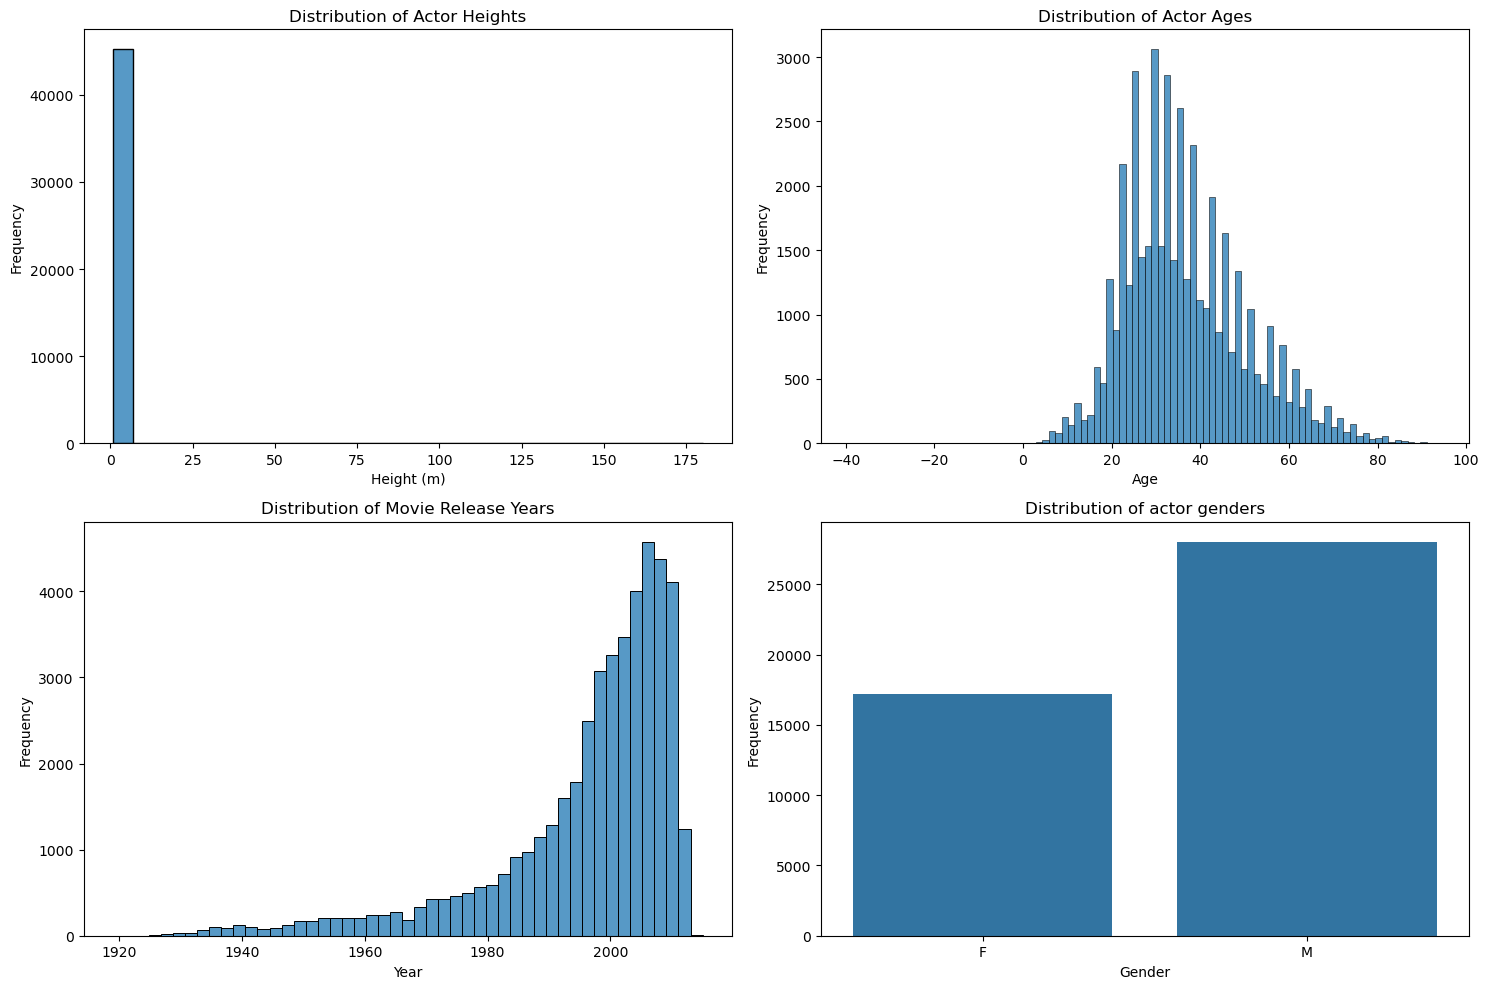

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(clean_data['Actor_Height'], bins=30, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Actor Heights')
axs[0, 0].set_xlabel('Height (m)')
axs[0, 0].set_ylabel('Frequency')

sns.histplot(clean_data['Actor_Age_At_Movie_Release'], bins=92, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of Actor Ages')
axs[0, 1].set_xlabel('Age')
axs[0, 1].set_ylabel('Frequency')

sns.histplot(clean_data['Movie_Release_Year'], bins=49, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of Movie Release Years')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Frequency')

sns.countplot(data=clean_data, x='Actor_Gender', ax=axs[1, 1])
axs[1, 1].set_title('Distribution of actor genders')
axs[1, 1].set_xlabel('Gender')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Although we removed empty values, we can still clearly observe aberrant values.


#### 4.2.2 Dropping aberrant values



We can see that even if there are no empty value, some values seem aberrant. We will get rid of these aberrant values.


In [63]:
clean_data = clean_data[clean_data['Actor_Height'] > 0]
clean_data = clean_data[clean_data['Actor_Height'] < 3]
clean_data = clean_data[clean_data['Actor_Age_At_Movie_Release'] > 0]
clean_data = clean_data[clean_data['Actor_Age_At_Movie_Release'] < 110]
clean_data = clean_data[clean_data['Movie_Release_Year'] > 1850]
clean_data = clean_data[clean_data['Movie_Release_Year'] < 2020]
clean_data = clean_data[clean_data['Actor_YOB'] > 1840]
clean_data = clean_data[clean_data['Actor_YOB'] < 2020]


print("Length of cleaned data after removing aberrant values: ", len(clean_data))

Length of cleaned data after removing aberrant values:  45236


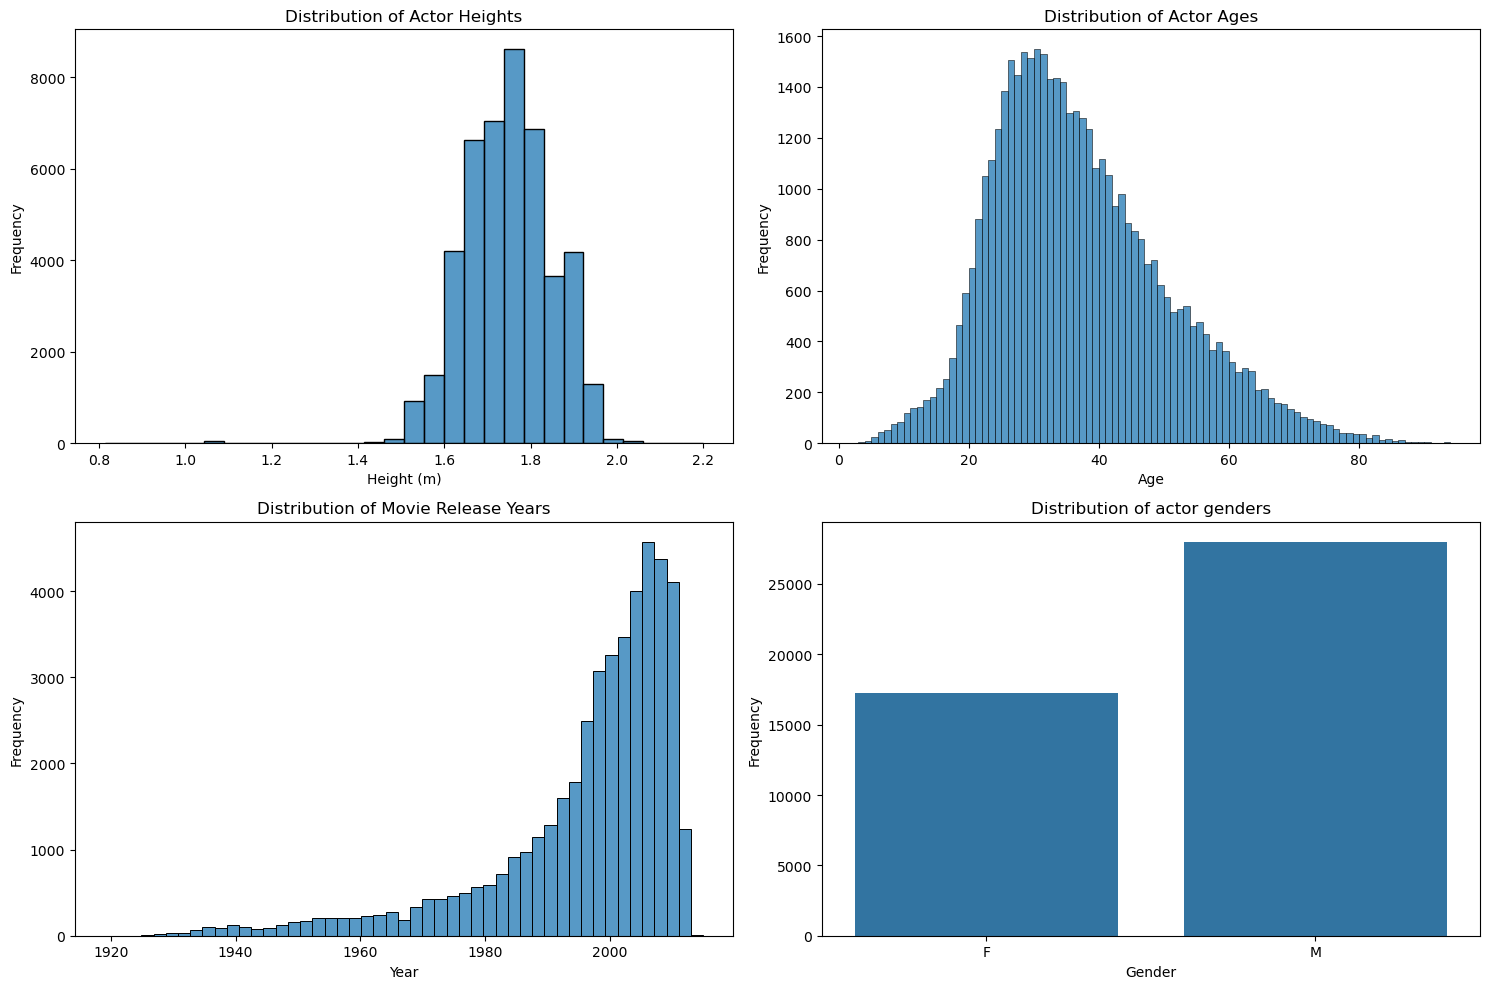

In [64]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(clean_data['Actor_Height'], bins=30, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Actor Heights')
axs[0, 0].set_xlabel('Height (m)')
axs[0, 0].set_ylabel('Frequency')

sns.histplot(clean_data['Actor_Age_At_Movie_Release'], bins=92, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of Actor Ages')
axs[0, 1].set_xlabel('Age')
axs[0, 1].set_ylabel('Frequency')

sns.histplot(clean_data['Movie_Release_Year'], bins=49, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of Movie Release Years')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Frequency')

sns.countplot(data=clean_data, x='Actor_Gender', ax=axs[1, 1])
axs[1, 1].set_title('Distribution of actor genders')
axs[1, 1].set_xlabel('Gender')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Now the data seem reasonable ! However, dropping all the empty values led to a significant decrease in the amount of data, and we probably dropped some useful information for our analysis.

We will now start again the exact same preprocessing from the original dataset, but we will focus on our subject, and drop only the empty values of the categories we are interested in.




### 4.3 Taking into acount our subject

We are studying the impact of 9/11 on the movie industry. In this dataset, we are particularly interested in the release year and the actor ethnicity. We will get rid of all the useless columns.

First of all, we are interested in the column "ethnicity", so we need to create a function that maps from FreebaseID to the corresponding label. To do so, we use the freebase-wikidata-mapping dataset found here : https://www.kaggle.com/datasets/latebloomer/freebase-wikidata-mapping/data.


In [ ]:
def freebase2label(freebase_id, mapping_dataframe):
    label = mapping_dataframe[mapping_dataframe['freebase_id'] == freebase_id]['label']
    if len(label) > 0:
        return label.values[0]
    else:
        return None
    
file_path = r"..\..\data\freebase_mapping.tsv"
freebase_mapping_df = pd.read_csv(file_path, sep='\t')



Before applying our function, we first need to clean the dataset. Let's first remove the columns we're not interested in.


In [ ]:
dataset = character_metadata.copy()
dataset = dataset.drop(columns=['Movie_Release_Date', 'Actor_DOB', 'Actor_Gender', 'Actor_Height', 'Actor_YOB'])
dataset.sample(5)



Depending on what feature we want to study, we drop the missing values in the corresponding columns.


In [ ]:
release_year_dataset = dataset.copy()
release_year_dataset = release_year_dataset.dropna(subset=['Movie_Release_Year'])

ethnicity_dataset = dataset.copy()
ethnicity_dataset = ethnicity_dataset.dropna(subset=['Actor_Ethnicity'])

no_nan_dataset = dataset.copy()
no_nan_dataset = no_nan_dataset.dropna()

print("Length of original dataset: ", len(dataset))

print("Length of dataset with no NaN values in Movie_Release_Year: ", len(release_year_dataset))
print("Length of dataset with no NaN values in Actor_Ethnicity: ", len(ethnicity_dataset))
print("Length of dataset with no NaN values at all: ", len(no_nan_dataset))

In [ ]:
release_year_dataset = release_year_dataset[release_year_dataset['Actor_Age_At_Movie_Release'] > 0]
release_year_dataset = release_year_dataset[release_year_dataset['Actor_Age_At_Movie_Release'] < 110]
release_year_dataset = release_year_dataset[release_year_dataset['Movie_Release_Year'] > 1850]
release_year_dataset = release_year_dataset[release_year_dataset['Movie_Release_Year'] < 2020]

print("Length of release year dataset after removing aberrant values: ", len(release_year_dataset))

ethnicity_dataset = ethnicity_dataset[ethnicity_dataset['Actor_Age_At_Movie_Release'] > 0]
ethnicity_dataset = ethnicity_dataset[ethnicity_dataset['Actor_Age_At_Movie_Release'] < 110]
ethnicity_dataset = ethnicity_dataset[ethnicity_dataset['Movie_Release_Year'] > 1850]
ethnicity_dataset = ethnicity_dataset[ethnicity_dataset['Movie_Release_Year'] < 2020]

print("Length of ethnicity dataset after removing aberrant values: ", len(ethnicity_dataset))

no_nan_dataset = no_nan_dataset[no_nan_dataset['Actor_Age_At_Movie_Release'] > 0]
no_nan_dataset = no_nan_dataset[no_nan_dataset['Actor_Age_At_Movie_Release'] < 110]
no_nan_dataset = no_nan_dataset[no_nan_dataset['Movie_Release_Year'] > 1850]
no_nan_dataset = no_nan_dataset[no_nan_dataset['Movie_Release_Year'] < 2020]

print("Length of no nan dataset after removing aberrant values: ", len(no_nan_dataset))



We can now check that the data seems reasonnably distributed and that it does not contain aberrant values.


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(release_year_dataset['Actor_Age_At_Movie_Release'], bins=102, ax=axs[0])
axs[0].set_title('Distribution of Actor Ages')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')

sns.histplot(release_year_dataset['Movie_Release_Year'], bins=54, ax=axs[1])
axs[1].set_title('Distribution of Movie Release Years')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ethnicity_dataset['Actor_Age_At_Movie_Release'], bins=102, ax=axs[0])
axs[0].set_title('Distribution of Actor Ages')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')

sns.histplot(ethnicity_dataset['Movie_Release_Year'], bins=54, ax=axs[1])
axs[1].set_title('Distribution of Movie Release Years')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Frequency')

plt.suptitle('Ethnicity Dataset')
plt.tight_layout()
plt.show()

### 4.4 Freebase to label 

Now that we have cleaned our data, we want to change the freebase IDs in the ethnicity column to labels that are understandable. To achieve this, we use the function previously introduced.

#### NOTE : the following cell takes 3hours to run 

In [ ]:
from tqdm import tqdm

no_nan_dataset.reset_index(drop=True, inplace=True)

for i in tqdm(range(len(no_nan_dataset))):
    no_nan_dataset.loc[i, 'Ethnicity_Label'] = freebase2label(no_nan_dataset['Actor_Ethnicity'].iloc[i], freebase_mapping_df)

# Drop rows that could not be mapped
no_nan_dataset = no_nan_dataset.dropna(subset='Ethnicity_Label')

In [ ]:
no_nan_dataset.to_csv(r"..\..\data\preprocessed_character_metadata.tsv", sep='\t', index=False)



That's about it ! The preprocessing is ready for our analysis on the character dataset !
